In [1]:
import pandas as pd
import numpy as np
import pickle
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
with open('./yeast_networks/processed_data/yeast_stress_feature_6138_174.pkl', 'rb') as f:
    yeast_stress_feature = pickle.load(f)
yeast_stress_feature.__len__()

6137

In [3]:
with open('./yeast_networks/processed_data/yeast_tf_names.pkl', 'rb') as f:
    yeast_tf_name = pickle.load(f)

In [4]:
yeast_tf_name.__len__()

536

In [5]:
gene_set = set(yeast_stress_feature.keys()) - yeast_tf_name

In [6]:
Chip_prior_yeast = pd.read_csv('./yeast_networks/priors/ChIP_prior.txt', sep='\t', header=None)
Ko_prior_yeast = pd.read_csv('./yeast_networks/priors/KO_prior.txt', sep='\t', header=None)

In [7]:
Chip_prior_yeast.shape, Ko_prior_yeast.shape

((245784, 3), (110487, 3))

In [8]:
chip_prior_pair = []
chip_pair_dict = {}
for row in Chip_prior_yeast.index:
    pair = (Chip_prior_yeast.loc[row, 0], Chip_prior_yeast.loc[row, 1])
    chip_prior_pair.append(pair)
    chip_pair_dict[pair] = Chip_prior_yeast.loc[row, 2]  

In [9]:
ko_prior_pair = []
ko_pair_dict = {}
for row in Ko_prior_yeast.index:
    pair = (Ko_prior_yeast.loc[row, 0], Ko_prior_yeast.loc[row, 1])
    ko_prior_pair.append(pair)
    ko_pair_dict[pair] = Ko_prior_yeast.loc[row, 2] 

In [10]:
common_pair = set(chip_prior_pair) & set(ko_prior_pair)

In [11]:
common_pair.__len__()

7027

In [12]:
joint_pair = set(chip_prior_pair) | set(ko_prior_pair)

In [13]:
joint_pair.__len__()

349244

In [14]:
prior_train_pos = []
# chip_prior_set = set(chip_prior_pair)
# pos_prior = Chip_prior_yeast[Chip_prior_yeast[2]>0.9]
gene_list = []
tf_list = []
for pair in common_pair:
    if pair[0] in yeast_tf_name and pair[1] in gene_set:
        prior_train_pos.append(pair)
        tf_list.append(pair[0])
        gene_list.append(pair[1])

prior_train_neg = []
while len(prior_train_neg)<len(prior_train_pos):
    tf_ = random.choice(tf_list)
    gene_ = random.choice(gene_list)
    if tf_ != gene_:
        tmp_pair = (tf_, gene_)
        if tmp_pair not in joint_pair:
            prior_train_neg.append(tmp_pair)
prior_train_pos.__len__(), prior_train_neg.__len__()

(6359, 6359)

In [15]:
# with open('train_prior3.pkl', 'wb') as f:
#     pickle.dump(train_pos, f)
#     pickle.dump(train_neg, f)

In [15]:
with open('./yeast_networks/processed_data/yeast_gold_stress.pkl', 'rb') as f:
    yeast_stress_gold = pickle.load(f)
yeast_stress_gold.__len__()

7797

In [42]:
yeast_stress_gold[0]

('YPR104C', 'YNL301C')

In [43]:
df = pd.DataFrame(yeast_stress_gold)

In [45]:
df.to_csv('./yeast_networks/gold/gold.csv', sep='\t', header=None, index=None)

In [17]:
#为gold数据按照tf分堆，以此训练分类器
tf_gene_dict = {}
for pair in yeast_stress_gold:
    try:
        tf_gene_dict[pair[0]].append(pair[1])
    except KeyError:
        tf_gene_dict[pair[0]] = [pair[1]]

tf_gene_count = []
for tf in tf_gene_dict.keys():
    tf_gene_count.append([tf, len(tf_gene_dict[tf])])
tf_gene_count = sorted(tf_gene_count, key=lambda x:x[1], reverse=True)

In [16]:
# tf_gene_count

In [24]:
import networkx as nx

In [27]:
def graph_matrix(edge_list):  # networkx 生成图，返回图的邻接矩阵，稀疏表达
    nodes = set()
    edges = []
    for edge in edge_list:
        from_node = edge[0]
        to_node = edge[1]
        edges.append(edge)
        nodes.add(from_node)
        nodes.add(to_node)
    G1 = nx.Graph()
    # node_num = len(nodes)
    for i in range(len(nodes)):
        G1.add_node(nodes.pop())
    for item in edges:
        G1.add_edge(item[0], item[1])
    return G1

In [34]:
G = graph_matrix(yeast_stress_gold)

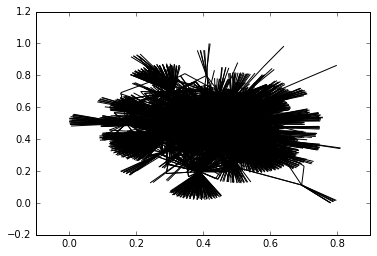

In [41]:
nx.draw_networkx_edges(G, pos=nx.spring_layout(G), node_size=30, font_size=0)

In [36]:
plt.show()

In [27]:
yeast_stress = pd.read_csv('./yeast_networks/gold/YEASTRACT_Type2.Stress_4282.txt', sep='\t', header=None)

In [28]:
yeast_stress.head()

,0,1
0,YNL216W,YPR079W
1,YPL248C,YBR020W
2,YMR016C,YGL125W
3,YEL009C,YGR124W
4,YLR223C,YJL178C


In [29]:
len(set(yeast_stress[0]) & yeast_tf_name)

119

In [30]:
len(set(yeast_stress[1]) & yeast_tf_name)

210

In [36]:
yeast_stress = yeast_stress.values

In [21]:
def split_by_tf(yeast_stress_gold):
    #为gold数据按照tf分堆，以此训练分类器
    tf_gene_dict = {}
    for pair in yeast_stress_gold:
        try:
            tf_gene_dict[pair[0]].append(pair[1])
        except KeyError:
            tf_gene_dict[pair[0]] = [pair[1]]

    tf_gene_count = []
    for tf in tf_gene_dict.keys():
        tf_gene_count.append([tf, len(tf_gene_dict[tf])])
    tf_gene_count = sorted(tf_gene_count, key=lambda x:x[1], reverse=True)
    return tf_gene_dict, tf_gene_count

In [32]:
tf_gene_dict, tf_gene_count = split_by_tf(yeast_stress)

In [199]:
tf_gene_count

[['YNL216W', 590],
 ['YHR084W', 478],
 ['YPR104C', 224],
 ['YEL009C', 197],
 ['YHR206W', 162],
 ['YMR037C', 150],
 ['YKL112W', 138],
 ['YML007W', 130],
 ['YBR049C', 110],
 ['YKL062W', 99],
 ['YER111C', 96],
 ['YLR403W', 95],
 ['YLR223C', 92],
 ['YMR016C', 90],
 ['YGL073W', 82],
 ['YGL013C', 75],
 ['YNL167C', 70],
 ['YDL020C', 63],
 ['YGL071W', 61],
 ['YNL027W', 56],
 ['YBL005W', 54],
 ['YER040W', 52],
 ['YDR216W', 45],
 ['YBR083W', 44],
 ['YKL109W', 37],
 ['YDR043C', 36],
 ['YOR028C', 36],
 ['YLR256W', 34],
 ['YPR065W', 32],
 ['YKR099W', 31],
 ['YDR146C', 30],
 ['YDR207C', 28],
 ['YFR034C', 27],
 ['YNL103W', 27],
 ['YDR310C', 25],
 ['YNL068C', 24],
 ['YAL051W', 23],
 ['YDL056W', 23],
 ['YLR176C', 23],
 ['YPL075W', 22],
 ['YLR131C', 22],
 ['YNL199C', 20],
 ['YPL089C', 20],
 ['YPL202C', 19],
 ['YOR363C', 19],
 ['YJL056C', 18],
 ['YGL035C', 18],
 ['YDR259C', 17],
 ['YPL049C', 17],
 ['YLR451W', 16],
 ['YBR182C', 15],
 ['YML027W', 15],
 ['YMR043W', 15],
 ['YOL108C', 15],
 ['YIL131C', 13],
 

In [37]:
def split_train_data(yeast_stress_gold, test_size=0.2):
    data_num = yeast_stress_gold.shape[0]
    train_num = int(data_num * (1-test_size))
    tf_gene_dict, tf_gene_count = split_by_tf(yeast_stress_gold)
    train_pair = []
    test_pair = []
    train_cnt = 0
    for item in tf_gene_count:
        train_cnt += item[1]
        if train_cnt <= train_num:
            for g in tf_gene_dict[item[0]]:
                train_pair.append([item[0], g])
        else:
            for g in tf_gene_dict[item[0]]:
                test_pair.append([item[0], g])
    return train_pair, test_pair


In [38]:
train_pair, test_pair = split_train_data(yeast_stress, 0.2)

In [41]:
train_pair.__len__(), test_pair.__len__()

(3396, 886)

In [51]:
#左边tf， 右边gene数量
# tg = 0
# tt = 0
# gt = 0
# gg = 0
# for row in range(yeast_stress.shape[0]):
#     g1 = yeast_stress.loc[row, 0]
#     g2 = yeast_stress.loc[row, 1]
#     if g1 in yeast_tf_name and g2 in gene_set:
#         tg +=1
#     if g1 in yeast_tf_name and g2 in yeast_tf_name:
#         tt +=1
#     if g1 in gene_set and g2 in yeast_tf_name:
#         gt +=1
#     if g1 in gene_set and g2 in gene_set:
#         gg +=1
#     else:
#         pass
# tg, tt, gt, gg

(3877, 398, 0, 7)

In [42]:
def make_pos_neg(pos_data):
    train_pos = []
    gene_list = []
    tf_list = []
    for pair in pos_data:
        if pair[0] in yeast_tf_name and pair[1] in gene_set:
            train_pos.append(pair)
            tf_list.append(pair[0])
            gene_list.append(pair[1])
        if pair[0] in yeast_tf_name and pair[1] in yeast_tf_name:
            train_pos.append(pair)
    train_neg = []
    while len(train_neg)<len(train_pos):
        tf1 = random.choice(tf_list)
        gene2 = random.choice(gene_list)
        if tf1 != gene2:
            tmp_pair = (tf1, gene2)
            if tmp_pair not in joint_pair:
                train_neg.append(tmp_pair)
    print(train_pos.__len__(), train_neg.__len__())
    return train_pos, train_neg

In [43]:
train_pos, train_neg = make_pos_neg(train_pair)

3396 3396


In [44]:
test_pos, test_neg = make_pos_neg(test_pair)

879 879


In [45]:
def transform_data_pkl(train_pos, train_neg, feature_dict):
    # 构造正例
    a_data = []
    b_data = []
    label = []
    # random.seed = 20
    for item in train_pos:
        regulatorA = feature_dict[item[0]]
        a_data.append(regulatorA)
        regulatorB = feature_dict[item[1]]
        b_data.append(regulatorB)
        label.append([0, 1])
    print('all pos sample is ', len(train_pos))

    # 构造负例
    for item in train_neg:
        regulatorA = feature_dict[item[0]]
        a_data.append(regulatorA)
        regulatorB = feature_dict[item[1]]
        b_data.append(regulatorB)
        label.append([1, 0])
    a_data = np.array(a_data)
    b_data = np.array(b_data)

    print('data transform done')
    train_x = [it for it in zip(a_data, b_data)]
    label = np.array(label)
    return train_x, label

In [46]:
yeast_train_x, yeast_train_y = transform_data_pkl(train_pos, train_neg, yeast_stress_feature)
yeast_test_x, yeast_test_y = transform_data_pkl(test_pos, test_neg, yeast_stress_feature)

all pos sample is  3396
data transform done
all pos sample is  879
data transform done


In [59]:
from sklearn.preprocessing import normalize

In [51]:
# l1 = [[1,2,3],[4,5,6],[7,8,9]]

# normalize(l1,norm='max')

In [47]:
# print(yeast_train_y[0])
# plt.plot(yeast_train_x[0][0], 'r')
# plt.plot(yeast_train_x[0][1], 'b')

In [48]:
# print(yeast_train_y[1])
# plt.plot(yeast_train_x[1][0], 'r')
# plt.plot(yeast_train_x[1][1], 'b')

In [49]:
# print(yeast_train_y[-1])
# plt.plot(yeast_train_x[-1][:173], 'r')
# plt.plot(yeast_train_x[-1][173:], 'b')

In [50]:
# print(yeast_train_y[-2])
# plt.plot(yeast_train_x[-2][:173], 'r')
# plt.plot(yeast_train_x[-2][173:], 'b')

In [52]:
def merge_ab(yeast_x):
    merged_ab = []
    for it in yeast_x:
        tmp = list(it[0])
        tmp.extend(list(it[1]))
#         tmp = it[1] - it[0]
        merged_ab.append(list(tmp))
    return np.array(merged_ab)

In [53]:
yeast_train_x = merge_ab(yeast_train_x)
yeast_test_x = merge_ab(yeast_test_x)
yeast_train_x.shape, yeast_test_x.shape

((6792, 346), (1758, 346))

In [55]:
yeast_train_y.shape

(6792, 2)

In [69]:
prior_yeast_train_x, prior_yeast_train_y = transform_data_pkl(prior_train_pos, prior_train_neg, yeast_stress_feature)
test_x = merge_ab(prior_yeast_train_x)

all pos sample is  6359
data transform done


In [70]:
test_x.shape, prior_yeast_train_y.shape

(12718, 346)

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scalar = StandardScaler()
scalar.fit(yeast_train_x)
yeast_train_x = scalar.transform(yeast_train_x)
yeast_test_x = scalar.transform(yeast_test_x)

In [187]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import  train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import BayesianRidge

In [92]:
# train_x, dev_x, train_y, dev_y = train_test_split(yeast_train_x, yeast_train_y[:,1], test_size=0.8)
# train_x.shape, train_y.shape

((1710, 346), (1710,))

In [197]:
# clf = RandomForestClassifier(500) #0.5540
# clf = LogisticRegression() #0.50
# clf = LinearSVC() #0.50
# clf = SVC() #0.58
# clf = KNeighborsClassifier(n_neighbors=10) #0.5616
#0.577
# clf = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, activation='relu', solver='adam', alpha=0.08, learning_rate='adaptive', learning_rate_init=0.001)
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(yeast_train_x, yeast_train_y[:,1])
test_pred_y = clf.predict(yeast_test_x)

In [198]:
precision_recall_fscore_support(y_pred=test_pred_y, y_true=yeast_test_y[:,1], average='binary')

(0.51622137404580148, 0.61547212741751989, 0.56149455111572388, None)

In [62]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(yeast_train_x, yeast_train_y[:,1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [63]:
test_pred_y = neigh.predict(yeast_test_x)

In [64]:
precision_recall_fscore_support(y_pred=test_pred_y, y_true=yeast_test_y[:,1], average='binary')

(0.56164383561643838, 0.41979522184300339, 0.48046875, None)

In [96]:
dist, ind = neigh.kneighbors(dev_x[:3], n_neighbors=10, return_distance=True)

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
cos_sim = cosine_similarity(yeast_train_x)

In [70]:
cos_sim = np.abs(cos_sim)

In [71]:
from heapq import nlargest

In [84]:
yeast_train_x.shape, yeast_train_y.shape

((6792, 346), (6792, 2))

In [109]:
def cal_Pc(yeast_train_x, yeast_train_y, topk=10):
    cos_sim = cosine_similarity(yeast_train_x)
    cos_sim = np.abs(cos_sim)
    Si = []
    L_12 = []
    Pc =[]
    for i in range(len(yeast_train_x)):
        top_10 = nlargest(topk, range(len(cos_sim[i])), cos_sim[i].take)[1:]
#         print(top_10)
        top_10_label = yeast_train_y[top_10]
#         print(top_10_label)
        sim_10 = cos_sim[i][top_10]
#         print(sim_10)
        Iij = []
        for it in top_10_label:
            if it == yeast_train_y[i]:
                Iij.append(-1)
            else:
                Iij.append(1)
        s = sum(Iij * sim_10)
        Si.append(s)
        l1 = sum(abs(sim_10))
        l2 = sum([it ** 2 for it in sim_10])
        L_12.append(l1 * l2)
    for si,li in zip(Si, L_12):
        if si >= 0:
            pc = 1 - 0.5 * np.exp(-0.5 * (si**4 / li**2))
            Pc.append(pc)
        else:
            pc = 0.5 * np.exp(-0.5 * (si**4 / li**2))
            Pc.append(pc)
    return Si, L_12, Pc

In [111]:
slp = cal_Pc(yeast_train_x, yeast_train_y[:,1])

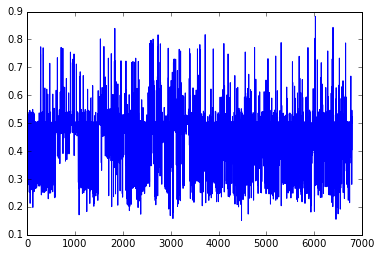

In [112]:
plt.plot(slp[2])

In [138]:
ll =[]
for it in S_x[2]:
    if it > 0.6 :
        ll.append(1)
len(ll)

210

In [139]:
len(ll) / len(S_x[2])

0.030918727915194347

In [136]:
5018 / 6792

0.7388103651354535